In [14]:
# Get everything setup for dedicated module loading

%load_ext autoreload
%autoreload 2
from renault.plot import *
from renault.get_data import get_pji_with_misssing_fluids_measure
from renault.knn_preprocessing import preprocess_data


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import OneClassSVM

from sklearn.cluster import KMeans

import plotly.graph_objects as go
import plotly.express as px

# Data Analysis Check

In [36]:
df = pd.read_csv('../data/train_df_LHA.csv',index_col='Unnamed: 0' )
filling = ['ActVolume', 'ActMass']
STEPS = ['StepLoading', 'StepEndLoading']

In [37]:
# conversion of string to datetime
time = pd.to_datetime(df.sourceTimestamp, infer_datetime_format=True)
df['time'] = time
df.sort_values('time', inplace=True)

# add time-delta feature order by pji > fluid > measurement
most_common_df = df.sort_values(['fluid', 'measurement', 'time'])
delta = most_common_df.groupby(['pji', 'fluid', 'measurement'])['time'].diff()
delta = delta.fillna(pd.Timedelta(seconds=0))
delta = delta / np.timedelta64(1, 's')
most_common_df['delta'] = delta.values
most_common_df

,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
310695,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:29.625000+00:00,810451,68.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:29.625000+00:00,0.000
313513,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:41.828000+00:00,810451,345.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:41.828000+00:00,12.203
305805,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:46.437000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:46.437000+00:00,4.609
310693,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:48.937000+00:00,810451,474.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:48.937000+00:00,2.500
315053,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:52.937000+00:00,810451,481.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-25 11:02:52.937000+00:00,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155787,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:37.640000+00:00,740170,1392.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:37.640000+00:00,0.781
162288,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:38.859000+00:00,740170,1393.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:38.859000+00:00,1.219
169504,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:40.359000+00:00,740170,1394.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:40.359000+00:00,1.500
152151,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-27 20:01:42.531000+00:00,740170,1395.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-27 20:01:42.531000+00:00,2.172


Number of steps for each type of measurements

In [24]:
df[df.measurement.isin(filling)].groupby(['fluid','pji', 'step', 'measurement'], as_index=False) \
    .agg({'dataValue': 'describe'}) \
    .groupby(['fluid',  'measurement','step']) \
    .count()

/Users/alix/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


pji dataValue                             
                                           count mean std min 25% 50% 75% max
fluid   measurement step                                                     
FRFluid ActVolume   StepEndLoading  42        42   42  25  42  42  42  42  42
                    StepLoading     58        58   58  58  58  58  58  58  58
RMFluid ActVolume   StepEndLoading   5         5    5   1   5   5   5   5   5
                    StepLoading     58        58   58  58  58  58  58  58  58

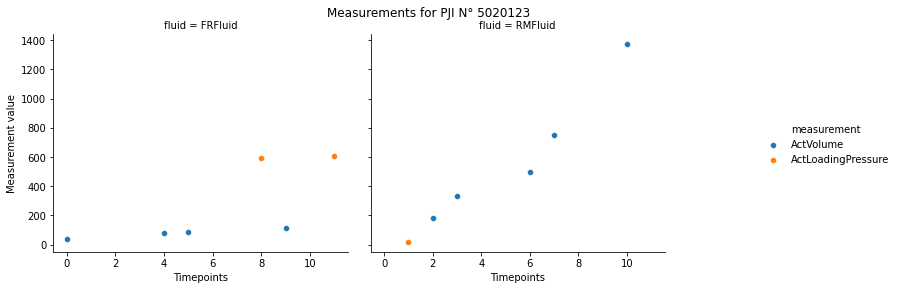

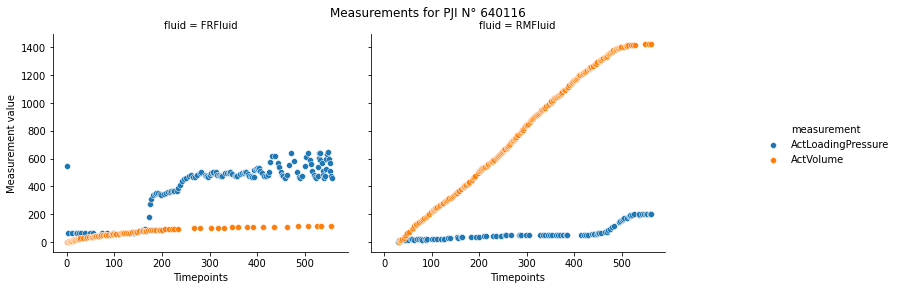

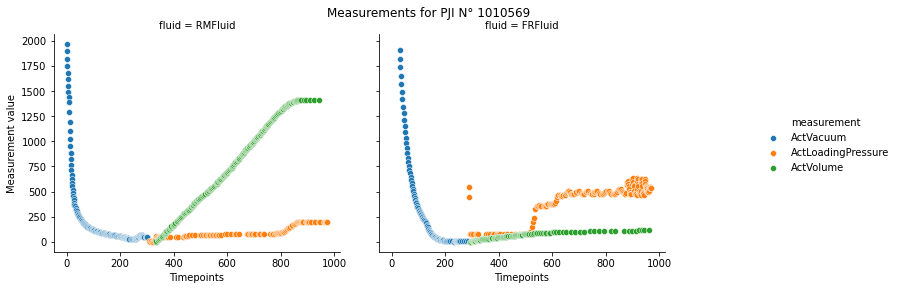

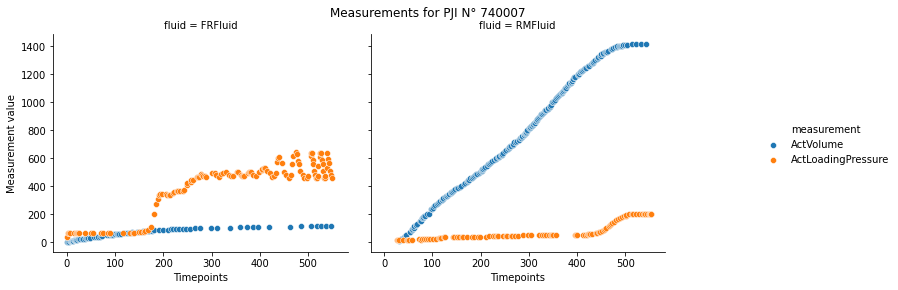

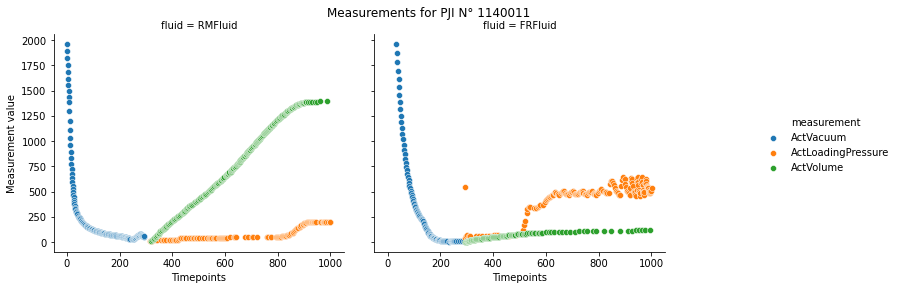

In [26]:
df.sourceTimestamp = pd.to_datetime(df.sourceTimestamp)
df.sort_values('sourceTimestamp', inplace=True)
for num in np.random.choice(df.pji.unique(), 5):
    plot_all_fluid(df,num)

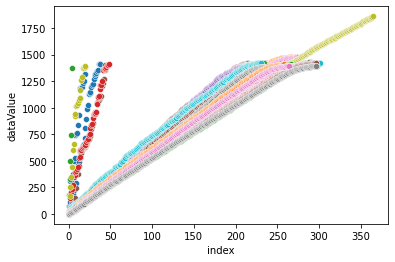

In [28]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActVolume')

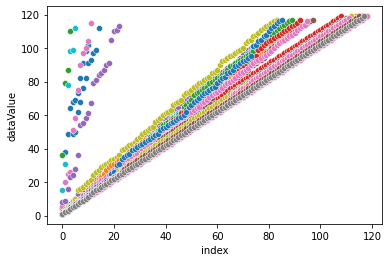

In [29]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActVolume')

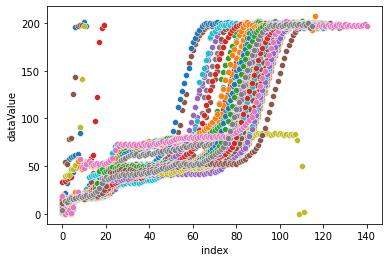

In [30]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'RMFluid', 'ActLoadingPressure')

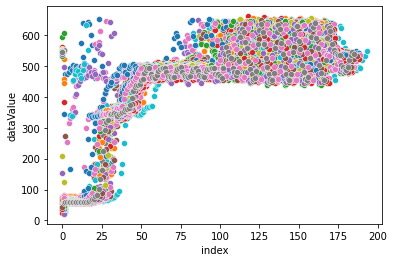

In [31]:
for num in df.pji.unique():
    plot_selective_fluid(df,num, 'FRFluid', 'ActLoadingPressure')

In [37]:
df[(df.dataValue > 1500) & (df.measurement == 'ActVolume') ]['pji'].unique()

array([4620256])

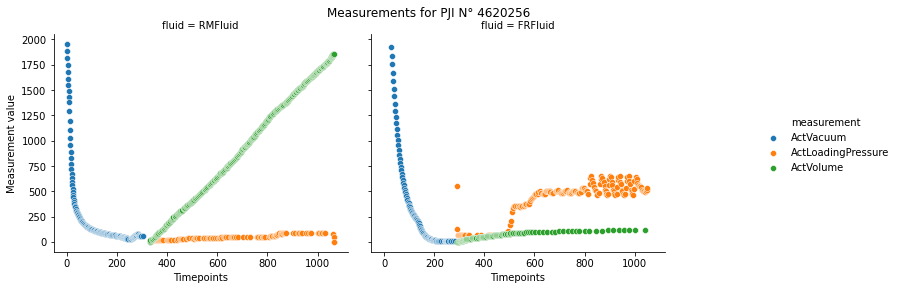

In [38]:
plot_all_fluid(df, 4620256)

In [39]:
df


,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type
313153,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVolume,StepLoading,2021-01-25 11:02:28.031000+00:00,810451,4.0,F82,DG,BVM6,NOT_HYBRID,M9R
312268,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:28.328000+00:00,810451,7.0,F82,DG,BVM6,NOT_HYBRID,M9R
313512,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:28.625000+00:00,810451,2.0,F82,DG,BVM6,NOT_HYBRID,M9R
310695,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:29.625000+00:00,810451,68.0,F82,DG,BVM6,NOT_HYBRID,M9R
306735,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActLoadingPressure,StepLoading,2021-01-25 11:02:30.234000+00:00,810451,55.0,F82,DG,BVM6,NOT_HYBRID,M9R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243647,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepEndLoading,2021-01-27 20:01:48.734000+00:00,740170,518.0,F82,DG,BVM6,NOT_HYBRID,M9R
161149,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVolume,StepEndLoading,2021-01-27 20:01:48.734000+00:00,740170,119.0,F82,DG,BVM6,NOT_HYBRID,M9R
244826,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepEndLoading,2021-01-27 20:01:48.859000+00:00,740170,537.0,F82,DG,BVM6,NOT_HYBRID,M9R
242098,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepEndLoading,2021-01-27 20:01:49.140000+00:00,740170,544.0,F82,DG,BVM6,NOT_HYBRID,M9R


# model fit

In [39]:
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df, n_fluids=2,n_measure=2)
bad_pji

[1240068, 320261]

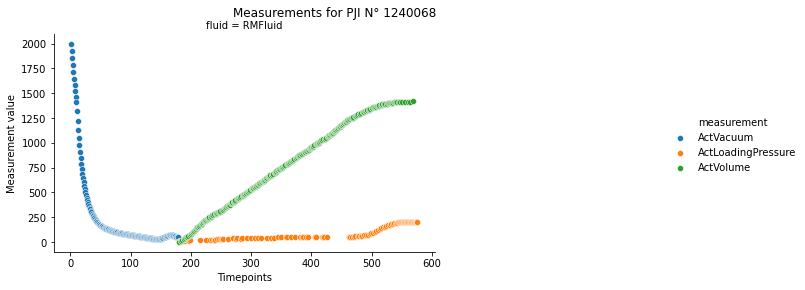

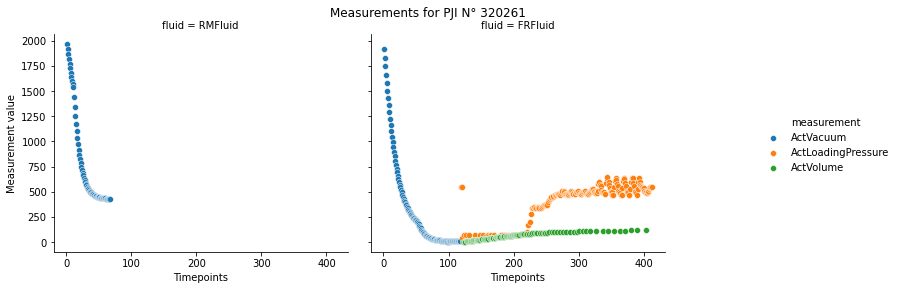

In [30]:
for pji in bad_pji:
    plot_all_fluid(df, pji)

In [46]:
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
#bad_pji = get_pji_with_misssing_fluids_measure(most_common_df)
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]
most_common_df = most_common_df[most_common_df['measurement'] != 'ActVacuum']

# Observations are PJI
# columns are the differents features regrouped by fluids and measurements
# important features
# Average dataValue in tail(10)
mean_tail_value = most_common_df.groupby(['pji', 'fluid', 'measurement']).tail(4)
mean_tail_value = mean_tail_value.groupby(['pji', 'fluid', 'measurement'])[['dataValue']].mean()
#mean_tail_value = mean_tail_value.reset_index()
mean_tail_value

summary = most_common_df\
.groupby(['pji', 'fluid', 'measurement'])['dataValue']\
.describe(percentiles=[0.1, 0.2, 0.8, 0.9]
)

summary = summary.drop(['count', 'std'], axis=1)

# Number of points in each group + average time delta
timing = most_common_df.groupby(['pji', 'fluid', 'measurement']).agg({'delta':['count', 'mean', 'max']})
timing

# Slope values (min max or q10, q90)
temp = most_common_df.copy()
temp = temp.sort_values(['fluid', 'measurement', 'time'])
slope = temp.groupby(['pji', 'fluid', 'measurement'])['dataValue'].diff()
temp = most_common_df.copy()
temp['slope'] = slope
temp = temp.groupby(['pji', 'fluid', 'measurement']).agg({'slope':["mean", "max"]})
#temp.reset_index(inplace=True)

temp

global_merged = pd.concat([mean_tail_value, timing, temp, summary], axis=1, join='inner')
column_list = global_merged.columns
final_df = global_merged.pivot_table(values=column_list, 
                   index = ['pji'],
                   columns=['fluid', 'measurement'], sort=False )

final_df

In [52]:
final_df.isnull().sum()

                fluid    measurement       
dataValue       FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(delta, count)  FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(delta, mean)   FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(delta, max)    FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    0
                         ActVolume             0
(slope, mean)   FRFluid  ActLoadingPressure    0
                         ActVolume             0
                RMFluid  ActLoadingPressure    1
                         

In [55]:
pipe = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='constant', fill_value=-5)
)
pipe.fit(final_df)
X = pipe.transform(final_df)

near = NearestNeighbors(n_neighbors=10)
near.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

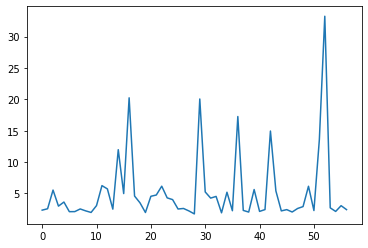

In [74]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = near.kneighbors(X)# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

<AxesSubplot:ylabel='Frequency'>

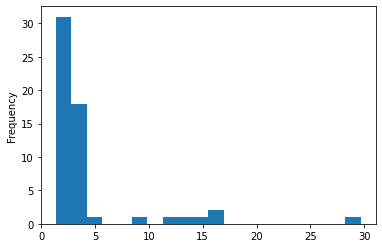

In [59]:
proximity = pd.Series(distances.mean(axis =1))
proximity.index = final_df.index
proximity.plot.hist(bins=20)

threshold = 5
proximity = proximity.sort_values(ascending=False)
proximity = proximity[proximity > threshold]
proximity

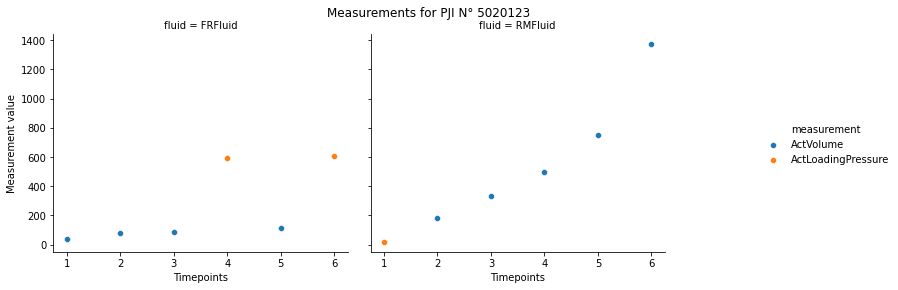

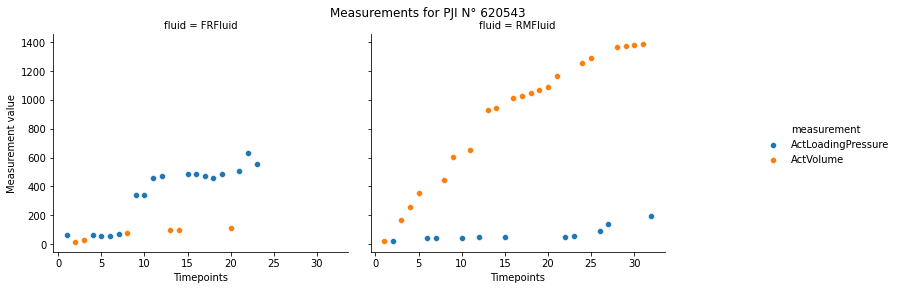

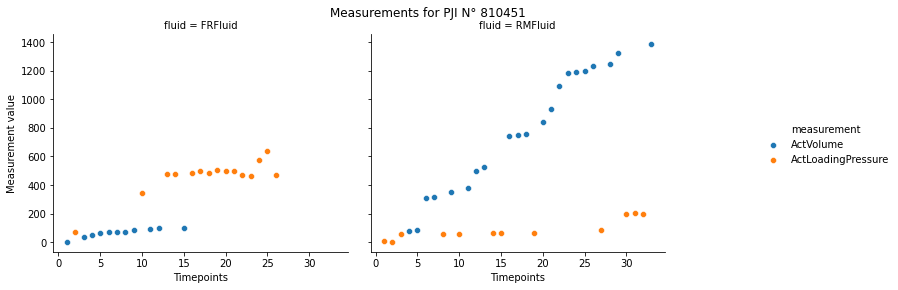

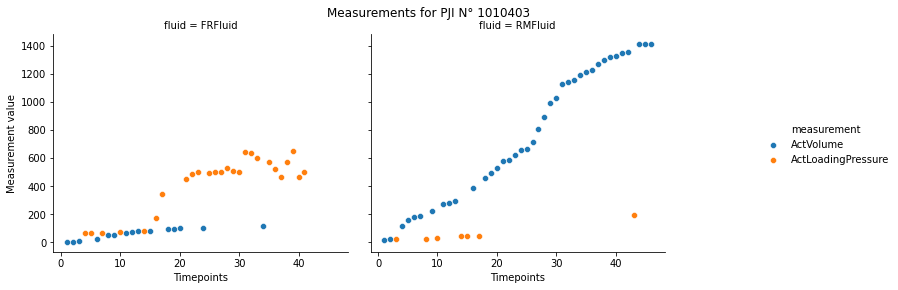

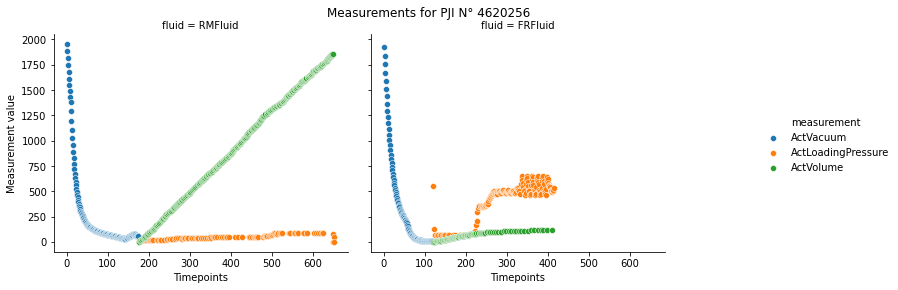

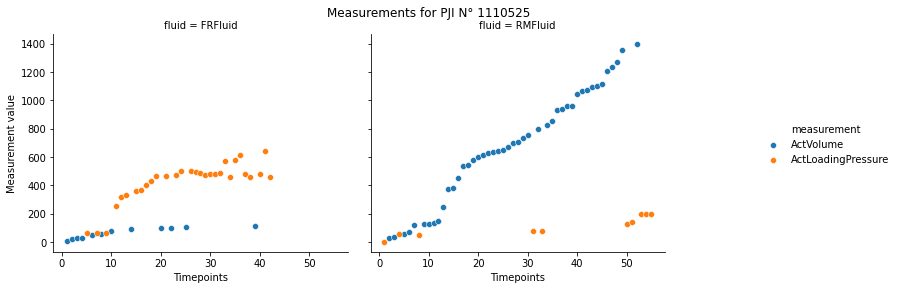

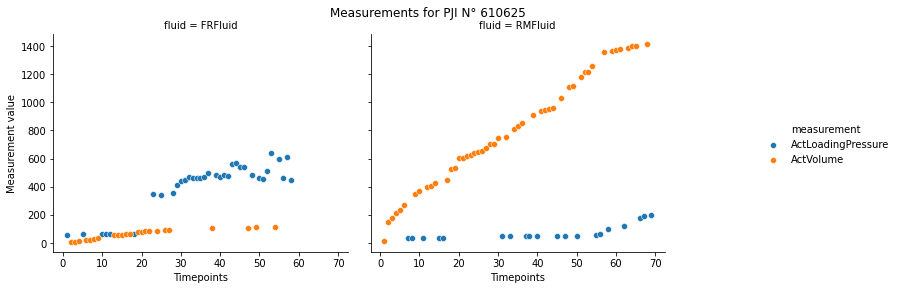

In [61]:
for pji in proximity.index:
    plot_all_fluid(df, pji)

In [68]:
test = pd.read_csv('../data/inference_df_LHA.csv')

test = test.dropna()
test

,Unnamed: 0,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type
0,2,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:38.687000+00:00,4730232.0,823.0,F82,DG,BVM6,NOT_HYBRID,M9R
1,3,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:51.906000+00:00,4730232.0,610.0,F82,DG,BVM6,NOT_HYBRID,M9R
2,5,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVolume,StepLoading,2021-01-28 11:04:23.796000+00:00,5230145.0,31.0,F82,DG,BVM6,NOT_HYBRID,M9R
3,11,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 11:04:29.703000+00:00,5230145.0,309.0,F82,DG,BVM6,NOT_HYBRID,M9R
4,24,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-01-28 10:50:40.796000+00:00,4730232.0,920.0,F82,DG,BVM6,NOT_HYBRID,M9R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60281,110428,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVacuum,StepVacuumControl,2021-02-01 15:18:46.968000+00:00,610521.0,4.0,F82,DG,BVM6,NOT_HYBRID,M9R
60282,110430,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVacuum,StepVacuumControl,2021-02-01 04:59:40.046000+00:00,520368.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R
60283,110431,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVacuum,StepVacuumControl,2021-02-01 16:07:25.140000+00:00,610490.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R
60284,110434,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActVacuum,StepVacuumControl,2021-02-01 19:04:24.843000+00:00,610496.0,7.0,F82,DG,BVM6,NOT_HYBRID,M9R


In [117]:
df = test
# conversion of string to datetime
time = pd.to_datetime(df.sourceTimestamp, infer_datetime_format=True)
df['time'] = time
df.sort_values('time', inplace=True)

# add time-delta feature order by pji > fluid > measurement
most_common_df = df.sort_values(['fluid', 'measurement', 'time'])
delta = most_common_df.groupby(['pji', 'fluid', 'measurement'])['time'].diff()
delta = delta.fillna(pd.Timedelta(seconds=0))
delta = delta / np.timedelta64(1, 's')
most_common_df['delta'] = delta.values
most_common_df

,Unnamed: 0,siteCode,objectUAI,machine,fluid,measurement,step,sourceTimestamp,pji,dataValue,body_type,driving_side,gearbox_type,hybrid_level,engine_type,time,delta
1261,8336,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.296000+00:00,4730232.0,540.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.296000+00:00,0.000
737,3557,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.687000+00:00,4730232.0,42.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.687000+00:00,0.391
865,4446,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:18.906000+00:00,4730232.0,60.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:18.906000+00:00,0.219
784,3877,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.093000+00:00,4730232.0,61.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.093000+00:00,0.187
494,2199,FRLHA,A000003FY5,FillingStation_1,FRFluid,ActLoadingPressure,StepLoading,2021-01-28 10:50:19.406000+00:00,4730232.0,62.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-01-28 10:50:19.406000+00:00,0.313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29703,69715,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:10.343000+00:00,610468.0,1416.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:10.343000+00:00,0.593
39300,82340,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:11.234000+00:00,610468.0,1417.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:11.234000+00:00,0.891
36768,79039,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:12.343000+00:00,610468.0,1418.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:12.343000+00:00,1.109
32875,73900,FRLHA,A000003FY5,FillingStation_1,RMFluid,ActVolume,StepLoading,2021-02-01 20:07:14.140000+00:00,610468.0,1419.0,F82,DG,BVM6,NOT_HYBRID,M9R,2021-02-01 20:07:14.140000+00:00,1.797


In [82]:
most_common_df = most_common_df[most_common_df['measurement'] != 'ActVacuum']
bad_pji = get_pji_with_misssing_fluids_measure(most_common_df, 2, 2)
# Global organisation of the data
# remove pji without 3 fluids and 3 measurements
#bad_pji = get_pji_with_misssing_fluids_measure(most_common_df)
most_common_df = most_common_df[~most_common_df.pji.isin(bad_pji)]


# Observations are PJI
# columns are the differents features regrouped by fluids and measurements
# important features
# Average dataValue in tail(10)
mean_tail_value = most_common_df.groupby(['pji', 'fluid', 'measurement']).tail(4)
mean_tail_value = mean_tail_value.groupby(['pji', 'fluid', 'measurement'])[['dataValue']].mean()
#mean_tail_value = mean_tail_value.reset_index()
mean_tail_value

summary = most_common_df\
.groupby(['pji', 'fluid', 'measurement'])['dataValue']\
.describe(percentiles=[0.1, 0.2, 0.8, 0.9]
)

summary = summary.drop(['count', 'std'], axis=1)

# Number of points in each group + average time delta
timing = most_common_df.groupby(['pji', 'fluid', 'measurement']).agg({'delta':['count', 'mean', 'max']})
timing

# Slope values (min max or q10, q90)
temp = most_common_df.copy()
temp = temp.sort_values(['fluid', 'measurement', 'time'])
slope = temp.groupby(['pji', 'fluid', 'measurement'])['dataValue'].diff()
temp = most_common_df.copy()
temp['slope'] = slope
temp = temp.groupby(['pji', 'fluid', 'measurement']).agg({'slope':["mean", "max"]})
#temp.reset_index(inplace=True)

temp

global_merged = pd.concat([mean_tail_value, timing, temp, summary], axis=1, join='inner')
column_list = global_merged.columns
final_df = global_merged.pivot_table(values=column_list, 
                   index = ['pji'],
                   columns=['fluid', 'measurement'], sort=False )

final_df

dataValue                                         \
fluid                  FRFluid                      RMFluid             
measurement ActLoadingPressure ActVolume ActLoadingPressure ActVolume   
pji                                                                     
340192.0                552.50     116.5             198.50   1419.50   
340207.0                519.75     116.5             199.00   1415.50   
340369.0                519.50     112.5             197.25   1418.50   
340371.0                524.50     115.5             197.50   1418.50   
350077.0                516.75     116.5             197.75   1419.50   
350160.0                531.75     116.5             197.50   1415.50   
350285.0                536.00     115.5             199.00   1416.50   
410104.0                520.00     116.5             198.75   1419.50   
410123.0                539.75     112.5             197.25   1422.50   
410222.0                531.25     116.5             197.50   1416.50   
410234.0                547.50     116.5             199.00   1419.50   
410237.0                538.00     116.5             198.75   1394.50   
410339.0                539.75     117.5              34.25   1817.25   
410341.0                519.75     115.5             197.50   1395.50   
410438.0                541.75     116.5             199.75   1395.50   
410439.0                537.00     116.5             197.75   1413.50   
410512.0                533.25     116.5             197.50   1419.50   
420107.0                524.25     115.5             199.25   1417.50   
420238.0                538.75     116.5             200.25   1416.50   
420289.0                531.75     116.5             196.75   1394.50   
420295.0                521.75     116.5             197.75   1397.50   
420307.0                544.25     115.5             198.50   1395.50   
420337.0                516.50     116.5             198.00   1421.50   
430051.0                554.50     107.5             198.00   1395.50   
430083.0                530.50     115.5             198.00   1415.50   
430125.0                536.25     116.5             197.25   1399.50   
430135.0                529.25     116.5             197.75   1416.50   
440080.0                531.00     114.5             198.50   1399.50   
510118.0                536.50     116.5             197.50   1392.50   
510780.0                535.50     116.5             197.25   1418.50   
520272.0                525.50     115.5             198.00   1421.50   
520368.0                537.50     116.5             199.00   1417.50   
540364.0                538.50     116.5             197.75   1395.50   
540467.0                517.50     116.5             198.25   1420.50   
550254.0                541.25     116.5             199.00   1417.50   
550258.0                527.75     116.5             197.25   1397.50   
550265.0                528.00     115.5             197.50   1417.50   
550279.0                533.75     113.5             198.75   1423.50   
610069.0                539.75     116.5             199.50   1418.50   
610143.0                522.25     116.5             196.25   1393.50   
610225.0                523.75     115.5             198.25   1416.50   
610236.0                553.75     116.5             198.50   1417.50   
610242.0                529.25     116.5             199.25   1419.50   
610243.0                547.00     116.5             198.50   1393.50   
610251.0                527.00     116.5             198.00   1416.50   
610264.0                515.25     115.5             197.75   1419.50   
610393.0                545.25     117.5             199.50   1419.50   
610398.0                535.75     116.5             197.25   1395.50   
610408.0                523.50     115.5             197.50   1414.50   
610416.0                537.00     116.5             197.50   1417.50   
610468.0                528.25     116.5             198.00   1418.50   
610490

In [83]:
X_test = pipe.transform(final_df)
distances, indexes = near.kneighbors(X_test)

pji
430051.0    12.734641
410339.0    12.528083
dtype: float64

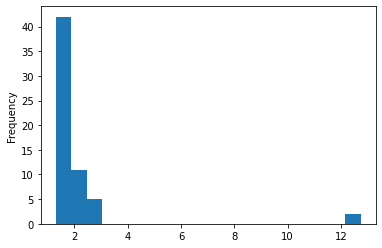

In [84]:
proximity = pd.Series(distances.mean(axis =1))
proximity.index = final_df.index
proximity.plot.hist(bins=20)

threshold = 5
proximity = proximity.sort_values(ascending=False)
proximity = proximity[proximity > threshold]
proximity

In [85]:
bad_pji

[420147.0]

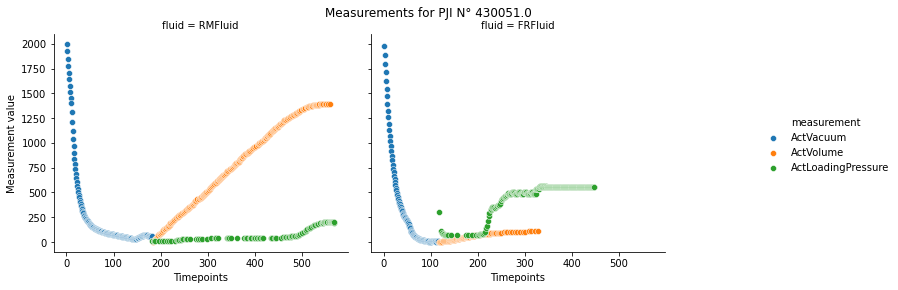

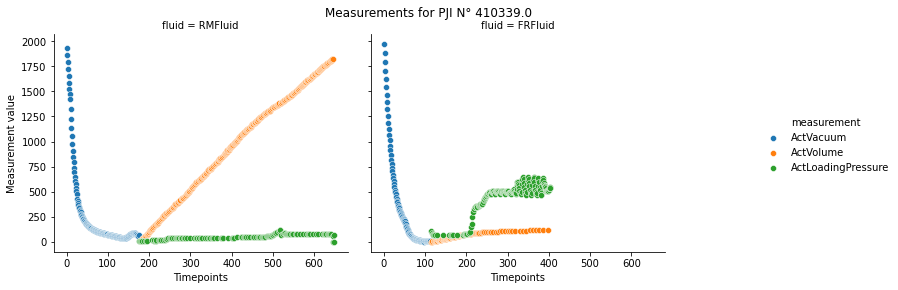

In [86]:
for pji in proximity.index:
    plot_all_fluid(df, pji)

In [80]:
len(df.pji.unique())

61

# Case of Junary 29th

Jump from 28/01 to 01/02

In [107]:
case = df[df.time.dt.month == 2]

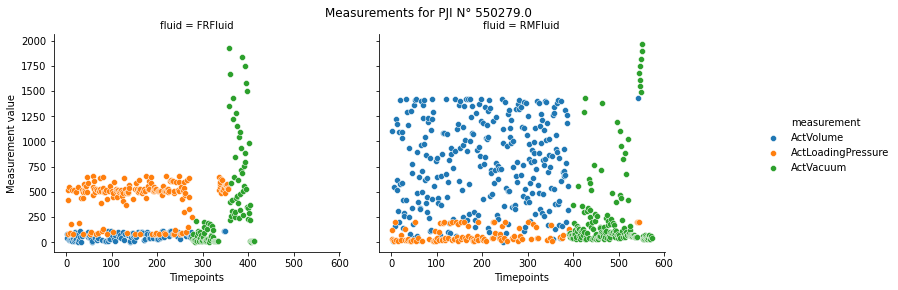

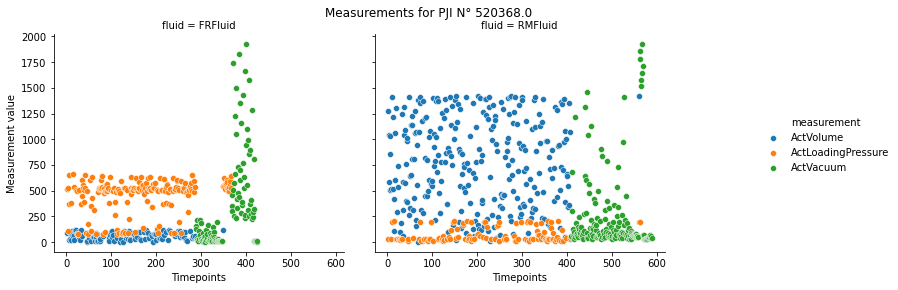

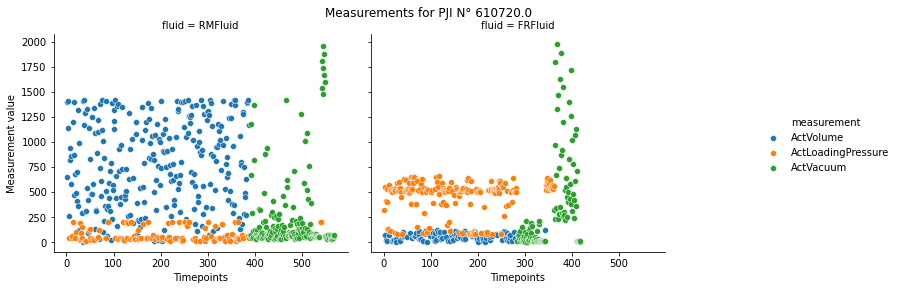

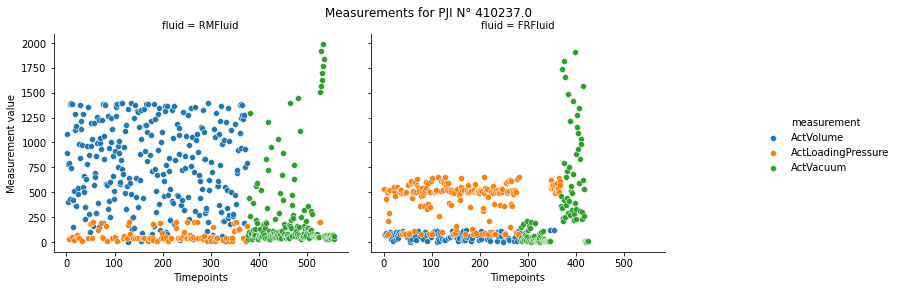

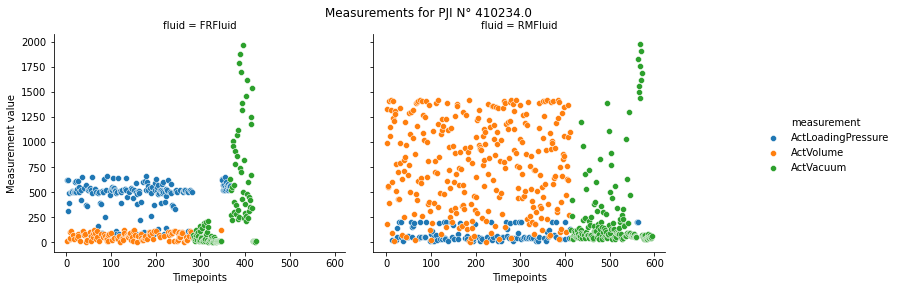

In [116]:
for pji in case.pji.unique()[:5]:
    plot_all_fluid(df, pji)

In [123]:
case = df.groupby('pji')['time'].mean().reset_index().tail()['pji']

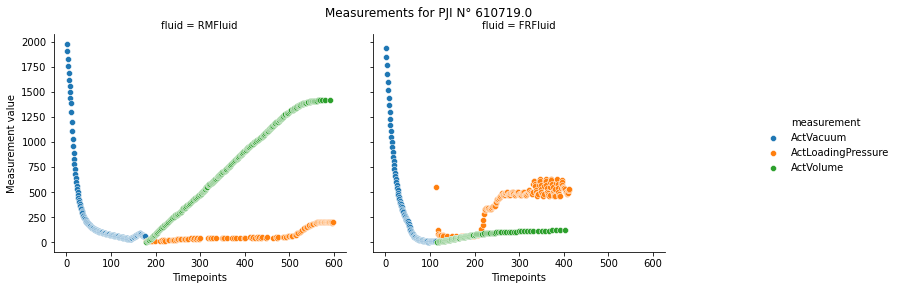

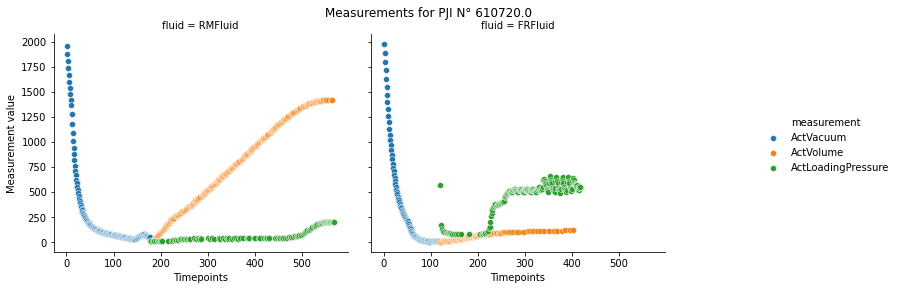

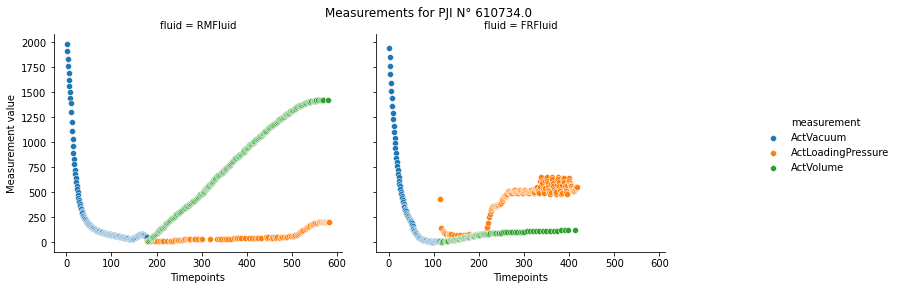

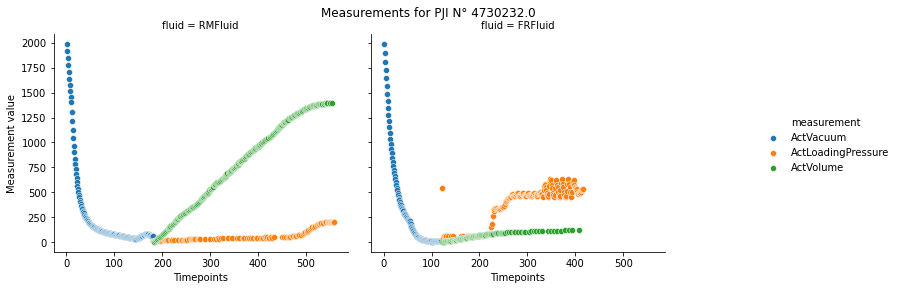

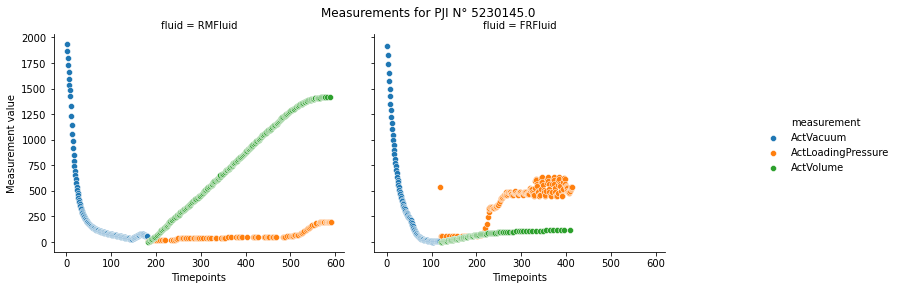

In [124]:
for pji in case:
    plot_all_fluid(df, pji)

In [132]:
temp = df.groupby(['pji', 'fluid'])['time'].min().reset_index()
temp = pd.pivot(temp, index=['pji'],values=['time'], columns=['fluid'])

In [134]:
temp.columns = ['FR', 'RM']

pji
340192.0     True
340207.0     True
340369.0     True
340371.0     True
350077.0     True
             ... 
610719.0     True
610720.0     True
610734.0     True
4730232.0    True
5230145.0    True
Length: 61, dtype: bool